In [94]:
import pandas as pd
import numpy as np

# --- Time Setup ---
years = np.arange(2025, 2101)
n_years = len(years)
sources = ["solar", "wind", "natural_gas", "oil", "coal", "other"]

# --- Constants ---
development_growth_rate = 0.02        # 2% annual growth
plant_development_time = 2            # years
plant_construction_time = 4           # years

# --- Initial Conditions (per source) ---
initial_development_starting = 10     # EJ/year, total across all sources
initial_development_share = {
    "solar": 0.06,
    "wind": 0.08,
    "natural_gas": 0.22,
    "oil": 0.03,
    "coal": 0.35,
    "other": 0.26
}
initial_development = 50              # EJ/year total
initial_supply = 500                  # EJ/year total
initial_share = initial_development_share  # same shares for supply

# --- Initialize Arrays ---
Elec_Capacity_under_development = {s: np.zeros(n_years) for s in sources}
Elec_Capacity_under_construction = {s: np.zeros(n_years) for s in sources}
Elec_Energy_supply_capacity = {s: np.zeros(n_years) for s in sources}

Elec_Capacity_construction_starting = {s: np.zeros(n_years) for s in sources}
Elec_Completing_capacity = {s: np.zeros(n_years) for s in sources}
Elec_Retiring_capacity = {s: np.zeros(n_years) for s in sources}  # Zero for now

# --- Set Initial Values ---
for s in sources:
    Elec_Capacity_under_development[s][0] = initial_development * initial_development_share[s]
    Elec_Capacity_under_construction[s][0] = 0
    Elec_Energy_supply_capacity[s][0] = initial_supply * initial_share[s]

# --- Simulation Loop ---
total_dev_starting = initial_development_starting

for t in range(1, n_years):
    total_dev_starting *= (1 + development_growth_rate)

    for s in sources:
        dev_starting = total_dev_starting * initial_development_share[s]
        Elec_Capacity_construction_starting[s][t] = Elec_Capacity_under_development[s][t-1] / plant_development_time
        Elec_Completing_capacity[s][t] = Elec_Capacity_under_construction[s][t-1] / plant_construction_time
        Elec_Retiring_capacity[s][t] = 0  # Set to 0 for simplicity

        # Stocks
        Elec_Capacity_under_development[s][t] = (
            Elec_Capacity_under_development[s][t-1]
            + dev_starting
            - Elec_Capacity_construction_starting[s][t]
        )

        Elec_Capacity_under_construction[s][t] = (
            Elec_Capacity_under_construction[s][t-1]
            + Elec_Capacity_construction_starting[s][t]
            - Elec_Completing_capacity[s][t]
        )

        Elec_Energy_supply_capacity[s][t] = (
            Elec_Energy_supply_capacity[s][t-1]
            + Elec_Completing_capacity[s][t]
            - Elec_Retiring_capacity[s][t]
        )

# --- Create DataFrame ---
df = pd.DataFrame({"Year": years})
for s in sources:
    df[f"Development_{s}"] = Elec_Capacity_under_development[s]
    df[f"Construction_{s}"] = Elec_Capacity_under_construction[s]
    df[f"Supply_{s}"] = Elec_Energy_supply_capacity[s]

print(df)

    Year  Development_solar  Construction_solar  Supply_solar  \
0   2025           3.000000            0.000000     30.000000   
1   2026           2.112000            1.500000     30.000000   
2   2027           1.680240            2.181000     30.375000   
3   2028           1.476845            2.475870     30.920250   
4   2029           1.387882            2.595325     31.539217   
..   ...                ...                 ...           ...   
71  2096           4.801316            8.891326    113.541570   
72  2097           4.897342            9.069152    115.764401   
73  2098           4.995289            9.250535    118.031689   
74  2099           5.095195            9.435546    120.344323   
75  2100           5.197099            9.624257    122.703210   

    Development_wind  Construction_wind  Supply_wind  Development_natural_gas  \
0           4.000000           0.000000    40.000000                11.000000   
1           2.816000           2.000000    40.000000     

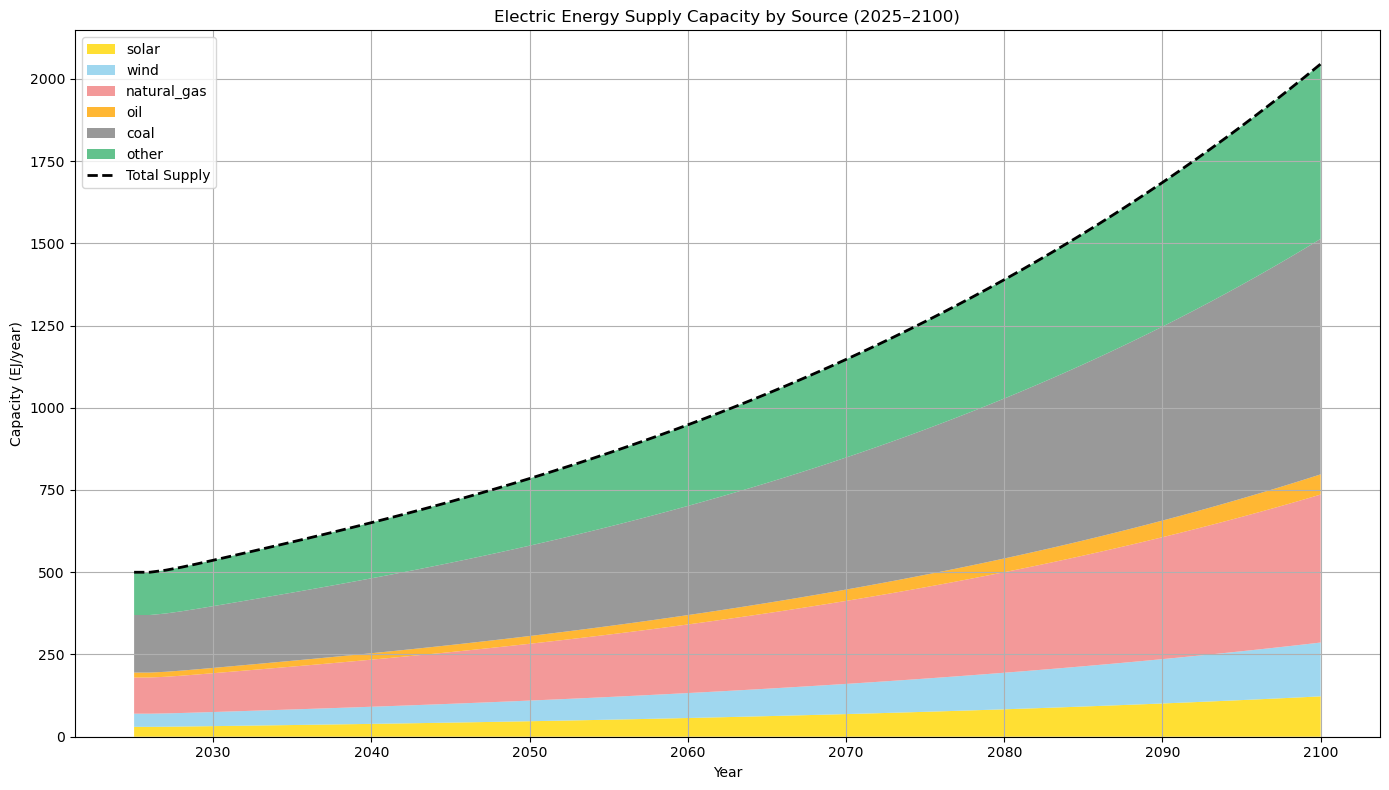

In [96]:
import matplotlib.pyplot as plt

# Compute total capacity across all sources
df["Total_Supply"] = df[[f"Supply_{s}" for s in sources]].sum(axis=1)

# Prepare stackplot data
stack_data = [df[f"Supply_{s}"].values for s in sources]
colors = ['gold', 'skyblue', 'lightcoral', 'orange', 'gray', 'mediumseagreen']

# Plot
plt.figure(figsize=(14, 8))
plt.stackplot(df["Year"].values, stack_data, labels=sources, colors=colors, alpha=0.8)
plt.plot(df["Year"].values, df["Total_Supply"].values, label="Total Supply", color="black", linestyle='--', linewidth=2)

plt.title("Electric Energy Supply Capacity by Source (2025–2100)")
plt.xlabel("Year")
plt.ylabel("Capacity (EJ/year)")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()
